In [1]:
%reload_kedro

2023-08-15 19:31:57,488 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/mba_Otavio
2023-08-15 19:31:57,685 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-08-15 19:31:57,798 - kedro.extras.extensions.ipython - INFO - ** Kedro project itaete_buy_prop
2023-08-15 19:31:57,799 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2023-08-15 19:31:57,806 - kedro.extras.extensions.ipython - INFO - Registered line magic `run_viz`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import array #useful to parse values

In [4]:
model = catalog.load("logreg_fitted_model")

X_test = catalog.load("master_table_teste_ftes")
y_test = catalog.load("master_table_teste_tgt")
y_pred = catalog.load("logreg_model_predict")

df_model_rpt = catalog.load("logreg_model_relatorio")

2023-08-15 19:31:58,655 - kedro.io.data_catalog - INFO - Loading data from `logreg_fitted_model` (PickleDataSet)...
2023-08-15 19:31:58,708 - kedro.io.data_catalog - INFO - Loading data from `master_table_teste_ftes` (ParquetDataSet)...
2023-08-15 19:31:58,752 - kedro.io.data_catalog - INFO - Loading data from `master_table_teste_tgt` (ParquetDataSet)...
2023-08-15 19:31:58,755 - kedro.io.data_catalog - INFO - Loading data from `logreg_model_predict` (ParquetDataSet)...
2023-08-15 19:31:58,757 - kedro.io.data_catalog - INFO - Loading data from `logreg_model_relatorio` (ParquetDataSet)...


In [5]:
model.get_params()

{'C': 0.5689866029018293,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [6]:
_roc_auc_score = roc_auc_score(y_true=y_test, y_score=y_pred)
_roc_auc_score

0.7660256410256411

In [7]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80       195
           1       0.35      0.85      0.50        40

    accuracy                           0.71       235
   macro avg       0.66      0.77      0.65       235
weighted avg       0.85      0.71      0.75       235



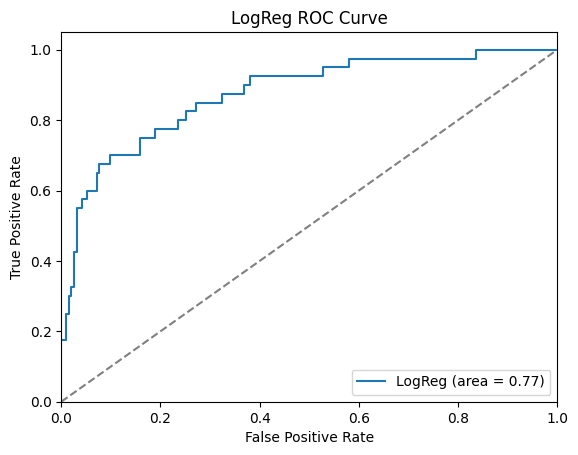

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure()

plt.plot(fpr, tpr, label="LogReg (area = %0.2f)" % _roc_auc_score)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("LogReg ROC Curve")
plt.legend(loc="lower right")

Text(0.5, 1.0, 'LogReg CM')

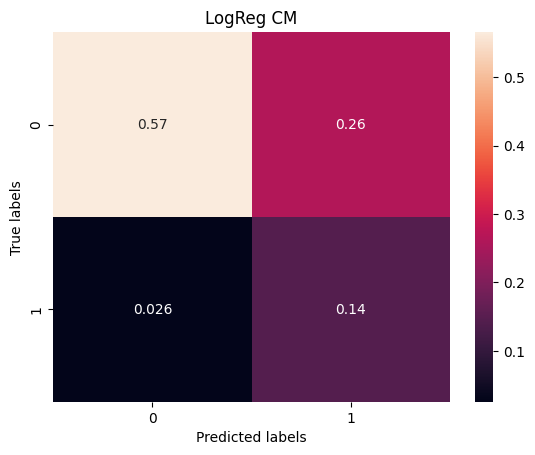

In [9]:
cm = eval(df_model_rpt["confusion_matrix"][0])

ax = plt.subplot()
plot = sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("LogReg CM")

In [10]:
cm

array([[0.56595745, 0.26382979],
       [0.02553191, 0.14468085]])